In [1]:
import os
import numpy as np
import pandas as pd
from sklearn.model_selection import cross_val_score
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
# from sklearn.model_selection import train_test_split

NUM_FULLY_COVERED = 1451
NUM_NOT_COVERED = 3664
NUM_NOT_FACE = 1114
NUM_PARTIALLY_COVERED = 392
NUM_OF_EACH_LABEL = [NUM_FULLY_COVERED, NUM_NOT_COVERED, NUM_NOT_FACE, NUM_PARTIALLY_COVERED]

LABELS = ["Fully covered", "Not covered", "Not face", "Partially covered"]

# Checks if feature data has been created locally
if not os.path.exists("mask_data.csv"):
    import featurize
    
data = np.array(pd.read_csv('mask_data.csv', sep=',',header=None))
X, Y = np.split(data, [-1], axis=1)
Y = Y.flatten()

scaler = StandardScaler()
X = scaler.fit_transform(X)

# X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.1, random_state=0)

# PCA dimensionality reduction

In [2]:
from sklearn.decomposition import PCA

def binary_search_helper(n, pca, target):
    left = 0
    right = n - 1
    ans = n - 1
    while left <= right:
        mid = (left + right) // 2
        variance = sum(pca.explained_variance_ratio_[:mid])    
        print("Explained variance ratio when mapping to {} dimensions is {}".format(
            mid + 1, variance
        ))
        if variance < target:
            left = mid + 1
        else:
            ans = mid
            right = mid - 1
    return ans


def required_dimensions(target, X, Y=None) -> int:
    """
    Returns the minimum number of dimensions we can reduce the dataset given by X and Y to 
    while keeping an explained variance of no less than target.
    """
    pca = PCA(n_components=X.shape[1])
    pca.fit(X, Y) if Y is not None else pca.fit(X)
    return binary_search_helper(X.shape[1] - 1, pca, target)

We can try mapping the data to retain 95% of the variance to reduce computational cost later

In [3]:
pca = PCA(n_components=required_dimensions(0.95, X, Y))
pca.fit(X, Y)
X_pca = pca.transform(X)
pca_output = np.hstack((X_pca, Y.reshape(-1, 1)))

Explained variance ratio when mapping to 2048 dimensions is 0.9991173820074848
Explained variance ratio when mapping to 1024 dimensions is 0.994290108120937
Explained variance ratio when mapping to 512 dimensions is 0.9832660266335495
Explained variance ratio when mapping to 256 dimensions is 0.9643798036645037
Explained variance ratio when mapping to 128 dimensions is 0.9351217853465772
Explained variance ratio when mapping to 192 dimensions is 0.9536304512256472
Explained variance ratio when mapping to 160 dimensions is 0.9458223480836135
Explained variance ratio when mapping to 176 dimensions is 0.9499909476548909
Explained variance ratio when mapping to 184 dimensions is 0.9518720934511978
Explained variance ratio when mapping to 180 dimensions is 0.9509506970127869
Explained variance ratio when mapping to 178 dimensions is 0.9504740696479506
Explained variance ratio when mapping to 177 dimensions is 0.9502330922148252


# Data visualization (Polynomial Kernel PCA)

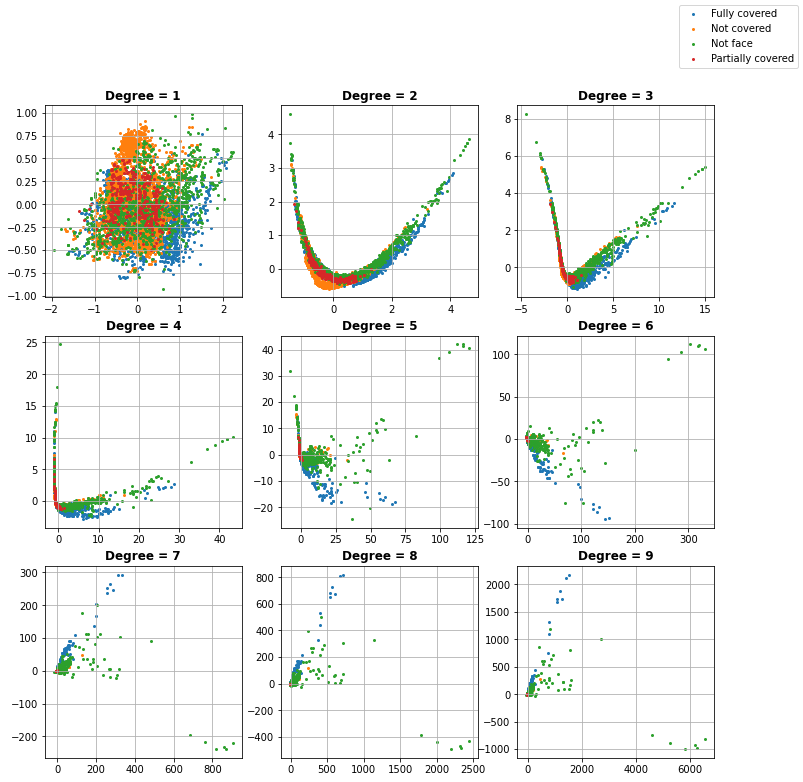

In [160]:
from sklearn.decomposition import KernelPCA
%matplotlib inline

def poly_kernel_pca_display(degrees):
    fig = plt.figure(num='Polynomial kernel PCA visualization', figsize=(12,12))
    fig.set_facecolor("white")
    plt.rcParams['figure.figsize'] = [100, 100]
    plt.rcParams['figure.dpi'] = 900
    for index, degree in enumerate(degrees):
        transformer = KernelPCA(n_components=2, kernel='poly', n_jobs=-1, degree=degree)
        X_kernelpca = transformer.fit_transform(X)
        plt.subplot(3, 3, index + 1)
        end_index = 0
        for label, population_size in enumerate(NUM_OF_EACH_LABEL):
            start_index = end_index
            end_index += population_size
            x_plt, y_plt = np.split(X_kernelpca[start_index:end_index,:], [1],axis=1)
            plt.scatter(x_plt, y_plt, s=4, label=LABELS[label])
            plt.title("Degree = {}".format(degree), fontdict={
                "fontsize": 12,
                "fontweight": "bold"
            })
        plt.grid()
    lines_labels = [fig.axes[0].get_legend_handles_labels()]
    lines, labels = [sum(lol, []) for lol in zip(*lines_labels)]
    fig.legend(lines, labels)
    
        
poly_kernel_pca_display(range(1, 10))

# Data Visualization (RBF Kernel PCA)

<IPython.core.display.Javascript object>


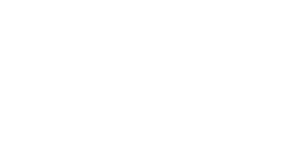

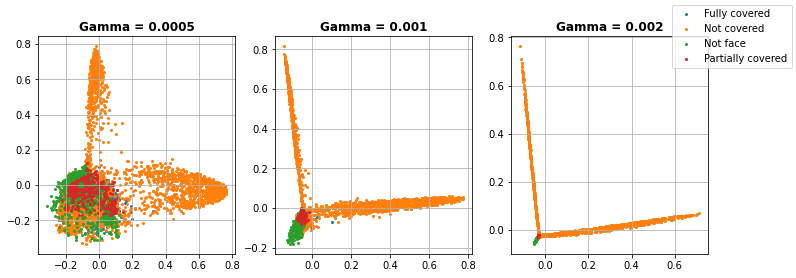

In [167]:
plt.clf()
%matplotlib inline
def rbf_kernel_pca_display(gammas):
    fig = plt.figure(num='Gaussian kernel PCA visualization', figsize=(12,4))
    fig.set_facecolor("white")
    plt.rcParams['figure.figsize'] = [100, 100]
    plt.rcParams['figure.dpi'] = 900
    for index, gamma in enumerate(gammas):
        transformer = KernelPCA(n_components=2, kernel='rbf', n_jobs=-1, gamma=gamma)
        X_kernelpca = transformer.fit_transform(X)
        plt.subplot(1, 3, index + 1)
        end_index = 0
        for label, population_size in enumerate(NUM_OF_EACH_LABEL):
            start_index = end_index
            end_index += population_size
            x_plt, y_plt = np.split(X_kernelpca[start_index:end_index,:], [1],axis=1)
            plt.scatter(x_plt, y_plt, s=4, label=LABELS[label])
            plt.title("Gamma = {}".format(gamma), fontdict={
                "fontsize": 12,
                "fontweight": "bold"
            })
        plt.grid()
    lines_labels = [fig.axes[0].get_legend_handles_labels()]
    lines, labels = [sum(lol, []) for lol in zip(*lines_labels)]
    fig.legend(lines, labels)
    
        
rbf_kernel_pca_display([.0005, .001, .002])

# Visualizing data with t-SNE

In [168]:
from sklearn.manifold import TSNE

X_embedded = TSNE(
    n_components=2, 
    learning_rate='auto', 
    init='random', 
    perplexity=5
).fit_transform(X)

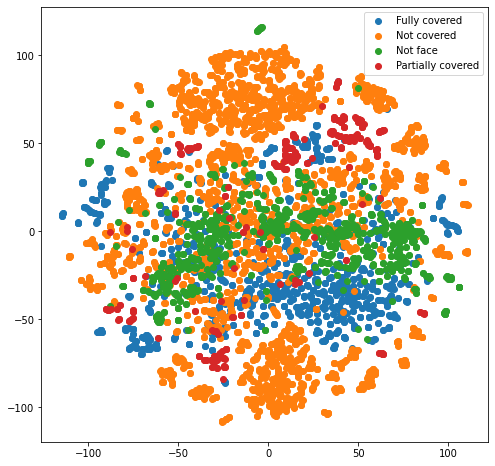

In [170]:
%matplotlib inline
fig = plt.figure(num='t-SNE visualization', figsize=(8,8))
fig.set_facecolor("white")

# fig, ax = plt.subplots()
end_index = 0
for label, population_size in enumerate(NUM_OF_EACH_LABEL):
    start_index = end_index
    end_index += population_size
    plt.scatter(X_embedded[start_index : end_index, 0], X_embedded[start_index : end_index, 1], label=LABELS[label])

plt.legend()

# Data visualization with ICA

In [164]:
from sklearn.decomposition import FastICA
transformer = FastICA(n_components=2)
X_ICA = transformer.fit_transform(X)

<IPython.core.display.Javascript object>


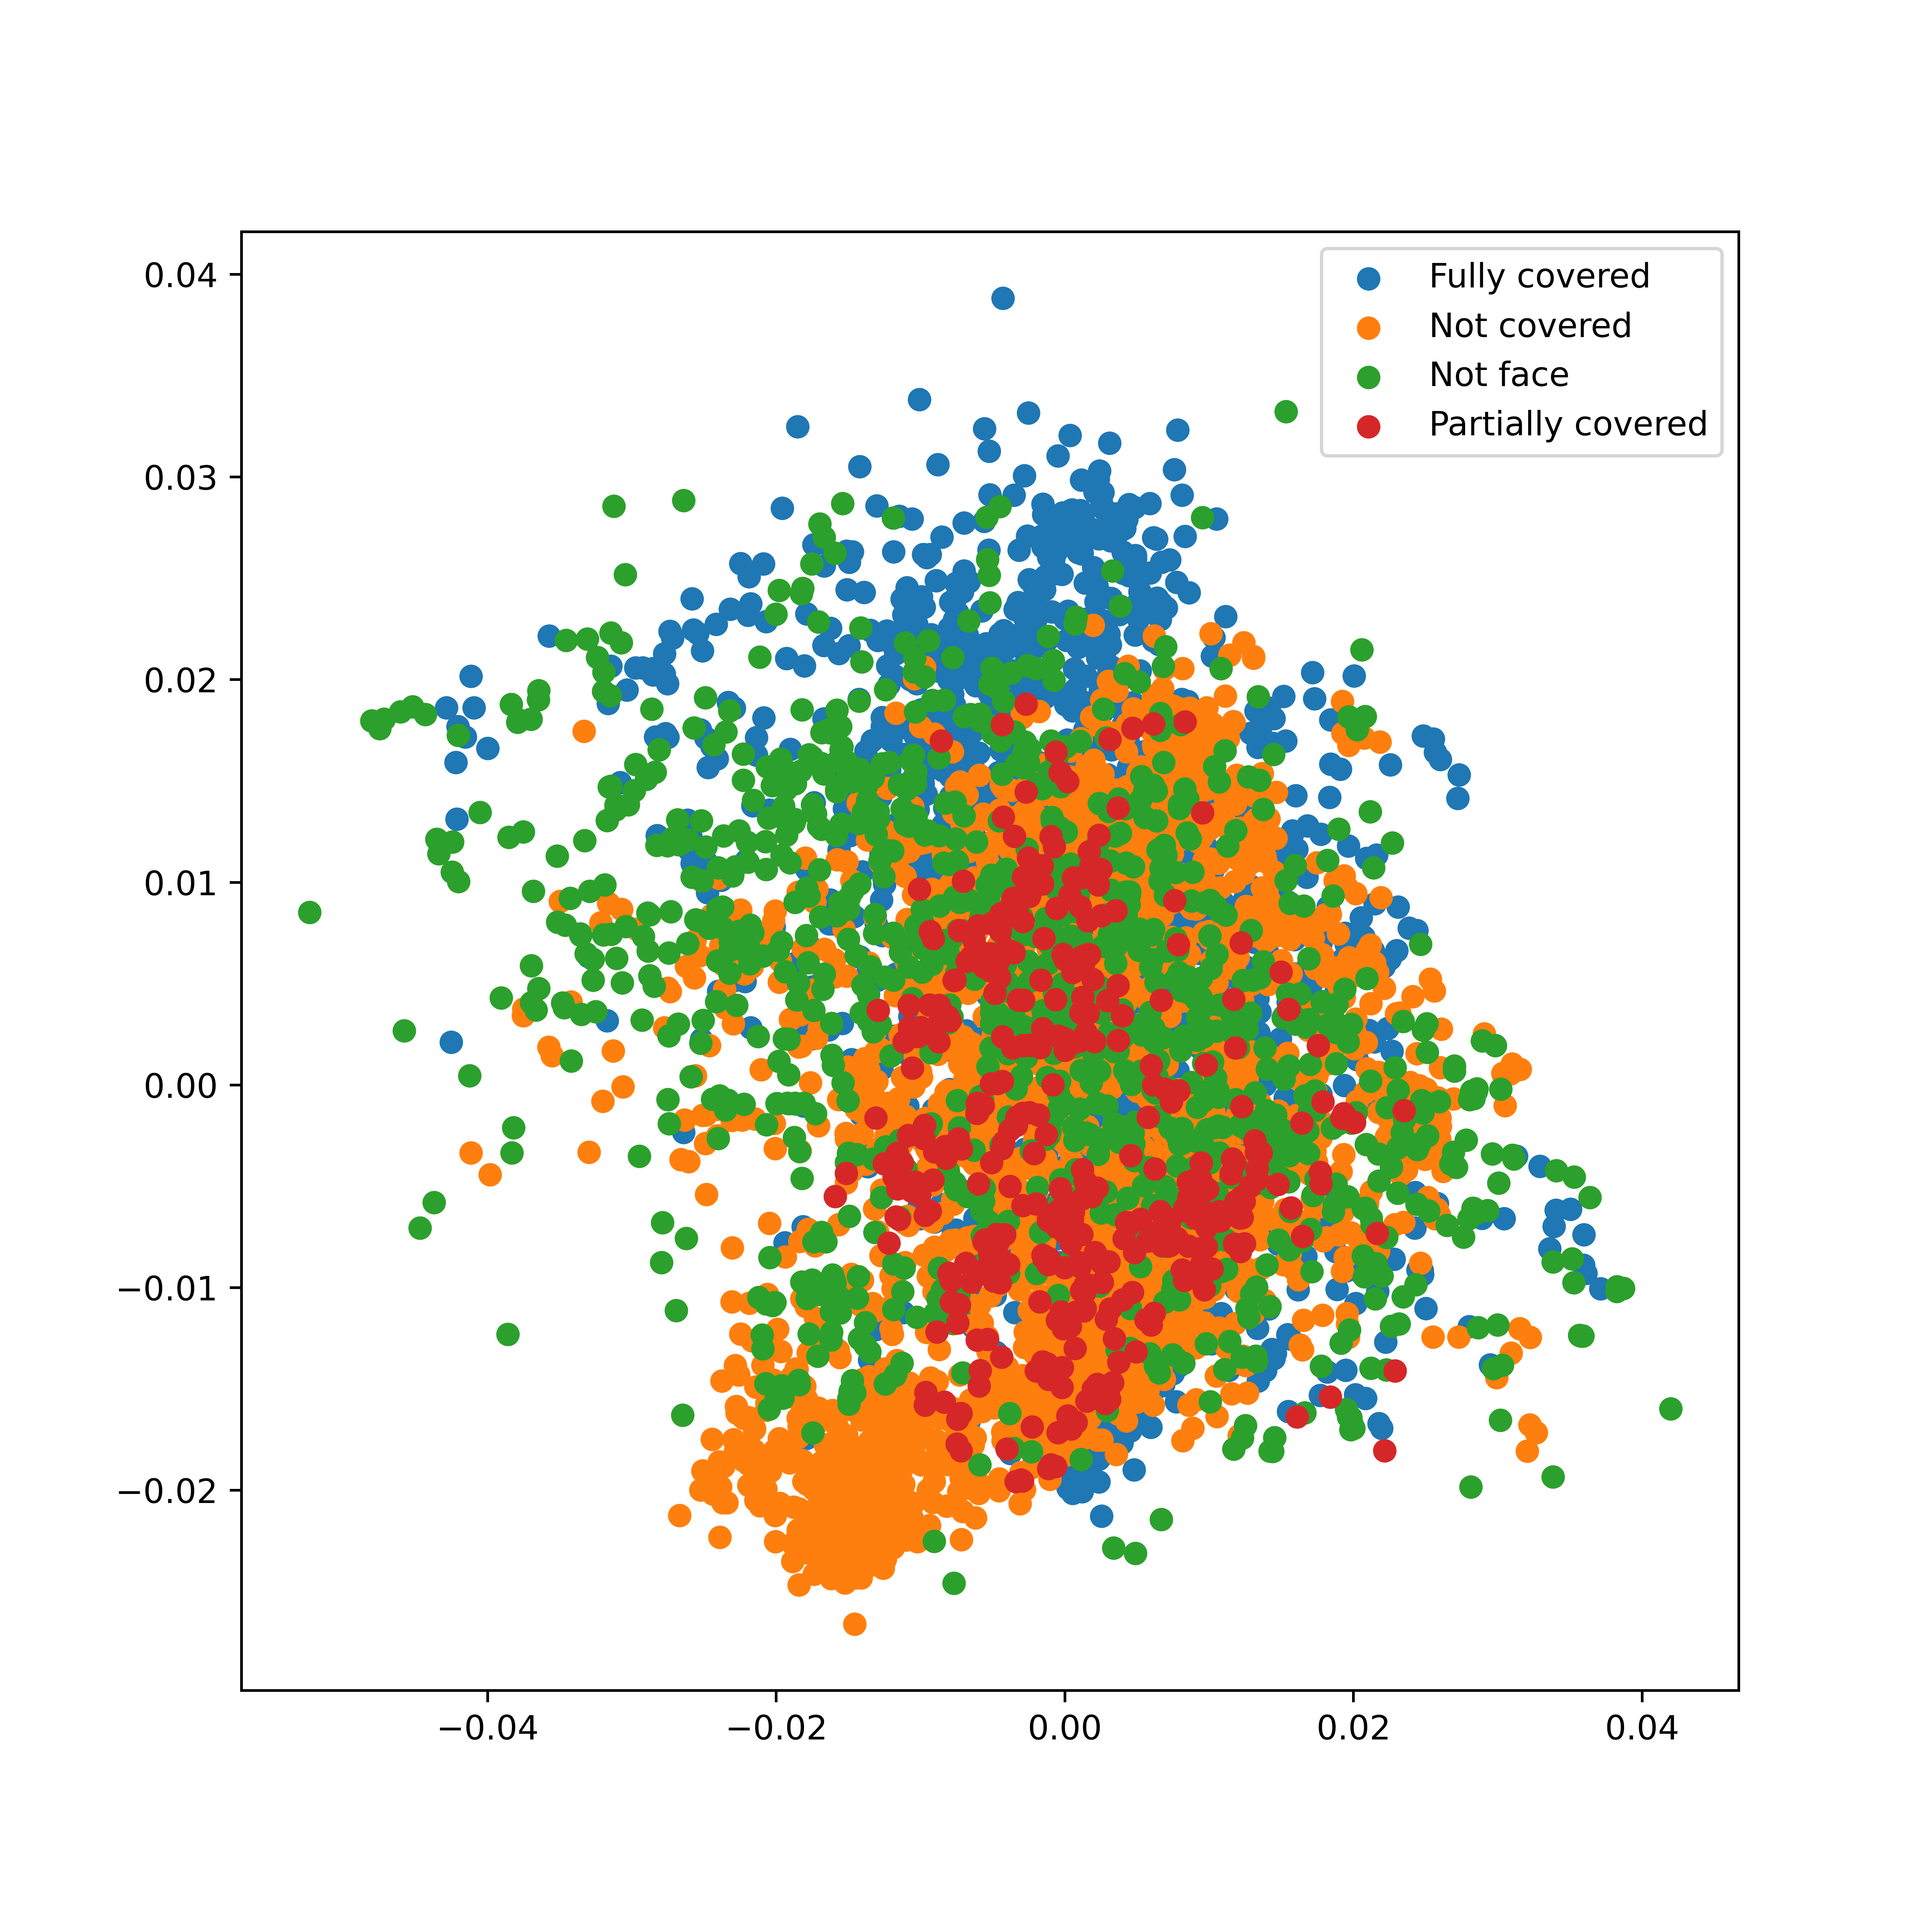

In [165]:
%matplotlib notebook
fig = plt.figure(num='ICA visualization', figsize=(8,8))
fig.set_facecolor("white")

# fig, ax = plt.subplots()
end_index = 0
for label, population_size in enumerate(NUM_OF_EACH_LABEL):
    start_index = end_index
    end_index += population_size
    plt.scatter(X_ICA[start_index : end_index, 0], X_ICA[start_index : end_index, 1], label=LABELS[label])

plt.legend()

# Model hyperparameter fitting

In [4]:
from sklearn.model_selection import GridSearchCV

def grid_search_and_refit(name, clf, param_grid, X_tr, Y_tr):
    searcher = GridSearchCV(
        estimator=clf(), 
        param_grid=param_grid, 
        scoring="balanced_accuracy",
        n_jobs=-1,
        verbose=3,
        cv=9
    )
    searcher.fit(X_tr, Y_tr)
    print("Best parameters for {} were: \n{}\nwith a validation accuracy of: {}".format(
        name, searcher.best_params_, searcher.best_score_,
    ))
    return searcher.best_estimator_

# First, we separate the test dataset. We chose to use PCA preprocessed data

In [5]:
from sklearn.model_selection import train_test_split

X_tr, X_te, Y_tr, Y_te = train_test_split(X_pca, Y, test_size = 0.1, random_state=0)

In [14]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC

def pows_of_x(start, end, base):
    """Returns all powers of x from [start, end] (inclusive)"""
    return [base ** p for p in range(start, end + 1)]

def pows_of_two(start, end):
    """Returns all powers of 2 from [start, end] (inclusive)"""
    return pows_of_x(start, end, 2)

# These will be used to run the initial telescopic grid search
techniques = [
    ('KNN', KNeighborsClassifier, {
        'n_neighbors': [i for i in range(1, 10)],
        'weights': ['uniform', 'distance'],
        'algorithm': ['auto', 'ball_tree', 'kd_tree'],
        'p': [1, 2],
    }),
    ('polySVM', SVC, {
        'C': pows_of_two(-3, 3),
        'kernel': ['poly'],
        'degree': [i for i in range(1, 10)],
        'gamma': ['scale', 'auto'] + pows_of_two(-12, 0),
        'coef0': [0, 1],
        'class_weight': ['balanced'],
        'max_iter': [1000000],
    }),
    ('gaussianSVM', SVC, {
        'C': pows_of_two(-3, 3),
        'kernel': ['rbf'],
        'gamma': ['scale', 'auto'] + pows_of_two(-12, 0),
        'class_weight': ['balanced'],
        'max_iter': [1000000],
    }),
    ('Decision Tree', DecisionTreeClassifier, {
        'max_depth': pows_of_two(5, 10),
        'max_features': ['sqrt', None],
        'min_samples_leaf': [1] + [2 * i for i in range(1, 10)],
        'min_samples_split': [2 * i for i in range(1, 20)]
    }), 
    ("Random Forest", RandomForestClassifier, {
        'n_estimators': pows_of_two(0, 7),
        'max_depth': pows_of_two(4, 8), 
        'min_samples_split': pows_of_two(1, 5), 
    }),
    ("Adaboost", AdaBoostClassifier, {
        'n_estimators': [200],
        'learning_rate': pows_of_x(-5, 1, 10),
        'algorithm': ['SAMME', 'SAMME.R']
    }),
    ("GradientBoost", GradientBoostingClassifier, {
        # Note that we leave loss function as deviance, as exponential loss gives
        # equivalent results with adaboost
        'n_estimators':pows_of_two(5, 8),
        'subsample': [i / 10 for i in range(2, 5)], # Minimize computational cost (stochastic)
        'min_samples_split': pows_of_two(1, 4), 
        'max_depth': [3, 4, 5],
        'max_features': ['auto'],
    })
]

def args_for(method_name):
    for name, func, param_grid in techniques:
        if name.lower() == method_name.lower():
            return name, func, param_grid

# Tuning for K-Nearest Neighbors

In [7]:
knn_model = grid_search_and_refit(*args_for("knn"), X_tr, Y_tr)

Fitting 9 folds for each of 108 candidates, totalling 972 fits
Best parameters for KNN were: 
{'algorithm': 'auto', 'n_neighbors': 1, 'p': 2, 'weights': 'uniform'}
with a validation accuracy of: 0.9181567938578292


In [8]:
ball_args = args_for("knn")
ball_args[2]['algorithm'] = ['ball_tree']
ball_tree_knn = grid_search_and_refit(*ball_args, X_tr, Y_tr)

Fitting 9 folds for each of 36 candidates, totalling 324 fits
Best parameters for KNN were: 
{'algorithm': 'ball_tree', 'n_neighbors': 1, 'p': 2, 'weights': 'uniform'}
with a validation accuracy of: 0.9181567938578292


# Tuning for polynomial kernel SVM

In [12]:
poly_svm_model = grid_search_and_refit(*args_for("polysvm"), X_tr, Y_tr)

Fitting 9 folds for each of 1890 candidates, totalling 17010 fits
Best parameters for polySVM were: 
{'C': 0.25, 'class_weight': 'balanced', 'coef0': 1, 'degree': 3, 'gamma': 0.00048828125, 'kernel': 'poly', 'max_iter': 1000000}
with a validation accuracy of: 0.928479174927776


Next we can carry out a linear grid search focusing on the region $C\in[1, 4]$ and $degree\in[2, 4]$

In [71]:
polysvm_args_v2 = ("polySVM", SVC, {
    'C': np.linspace(0.125, 5, num=10),
    'kernel': ['poly'],
    'degree': [i for i in range(2, 5)],
    'gamma': np.linspace(0.00048828125 / 2, 0.00048828125 * 2, num=10),
    'coef0': [1],
    'class_weight': ['balanced'],
    'max_iter': [1000000],
})

poly_svm_model = grid_search_and_refit(*polysvm_args_v2, X_tr, Y_tr)

Fitting 9 folds for each of 300 candidates, totalling 2700 fits
Best parameters for polySVM were: 
{'C': 0.125, 'class_weight': 'balanced', 'coef0': 1, 'degree': 3, 'gamma': 0.0005696614583333333, 'kernel': 'poly', 'max_iter': 1000000}
with a validation accuracy of: 0.9283807180161797


With no significant improvement to the validation loss, we cease hyperparameter fitting. We will use a cubic kernel SVM classifier with $C = 0.727$ on our test dataset when comparing the performance across methods.

# Tuning for Gaussian kernel SVM

In [21]:
gaussian_svm_model = grid_search_and_refit(*args_for("gaussiansvm"), X_tr, Y_tr)

Fitting 9 folds for each of 105 candidates, totalling 945 fits
Best parameters for gaussianSVM were: 
{'C': 4, 'class_weight': 'balanced', 'gamma': 0.000244140625, 'kernel': 'rbf', 'max_iter': 1000000}
with a validation accuracy of: 0.9368607185921989


In [9]:
gaussiansvm_args_v2 = ('gaussianSVM', SVC, {
    'C': np.linspace(2, 8, num=20),
    'kernel': ['rbf'],
    'gamma': np.linspace(0.000244140625 / 2, 0.000244140625 * 2, num=20),
    'class_weight': ['balanced'],
    'max_iter': [1000000],
})

gaussian_svm_model = grid_search_and_refit(*gaussiansvm_args_v2, X_tr, Y_tr)

Fitting 9 folds for each of 400 candidates, totalling 3600 fits
Best parameters for gaussianSVM were: 
{'C': 3.263157894736842, 'class_weight': 'balanced', 'gamma': 0.00031481291118421053, 'kernel': 'rbf', 'max_iter': 1000000}
with a validation accuracy of: 0.9392675854527204


# Tuning for Decision Tree

In [15]:
desicion_tree_model = grid_search_and_refit(*args_for("decision tree"), X_tr, Y_tr)

Fitting 9 folds for each of 2280 candidates, totalling 20520 fits
Best parameters for Decision Tree were: 
{'max_depth': 1024, 'max_features': None, 'min_samples_leaf': 1, 'min_samples_split': 10}
with a validation accuracy of: 0.7079955675419746


In [17]:
decision_tree_args_v2 = ("Decision Tree", DecisionTreeClassifier, {
    'max_depth': np.linspace(800, 2048, num=100, dtype=int),
    'max_features': [None],
    'min_samples_leaf': [1],
    'min_samples_split': [10]
})
decision_tree_model = grid_search_and_refit(*decision_tree_args_v2, X_tr, Y_tr)

Fitting 9 folds for each of 100 candidates, totalling 900 fits
Best parameters for Decision Tree were: 
{'max_depth': 1039, 'max_features': None, 'min_samples_leaf': 1, 'min_samples_split': 10}
with a validation accuracy of: 0.7100206772954216


Conclusion:

# Tuning for Random Forest

In [25]:
random_forest_model = grid_search_and_refit(*args_for("random forest"), X_tr, Y_tr)

Fitting 9 folds for each of 200 candidates, totalling 1800 fits
Best parameters for Random Forest were: 
{'max_depth': 32, 'min_samples_split': 2, 'n_estimators': 128}
with a validation accuracy of: 0.7777791977764246


We observe that the optimal hyperparameters for the grid above were at the upper end of `n_estimators` and `max_depth`, but the lower end of `min_samples_split`. We tightened the search on `min_samples_split` but increased the upper bound of the other 2 parameters. The computational cost scales strongly with `n_estimators` and thus we will not be increasing it past 512.

In [18]:
random_forest_args_v2 = (
    'Random Forest', RandomForestClassifier, {
        'n_estimators': [128],
        'max_depth': [i for i in range(16, 65)], 
        'min_samples_split': [2], 
    }
)
random_forest_model = grid_search_and_refit(*random_forest_args_v2, X_tr, Y_tr)

Fitting 9 folds for each of 49 candidates, totalling 441 fits
Best parameters for Random Forest were: 
{'max_depth': 26, 'min_samples_split': 2, 'n_estimators': 128}
with a validation accuracy of: 0.7795762176308831


The accuracy when increasing estimators and max depth only improves marginally, whereas training time becomes prohibitively high. As such, we cease parameter tuning here with a validation loss of $77.95\%$

# Tuning for AdaBoost

In our experiments, we primarily focused on the learning rate hyperparameter and not `n_estimators` as we found that it did not increase validation accuracy appreciably while increasing the training time drastically

In [27]:
adaboost_model = grid_search_and_refit(*args_for("adaboost"), X_tr, Y_tr)

Fitting 9 folds for each of 14 candidates, totalling 126 fits
Best parameters for Adaboost were: 
{'algorithm': 'SAMME.R', 'learning_rate': 1, 'n_estimators': 200}
with a validation accuracy of: 0.6883509471331486


We continue to do a telescopic search around the region of $0.1$ to $10$ as these surround the local optimum found

In [21]:
adaboost_args_v2 = ('Adaboost', AdaBoostClassifier, {
    'algorithm': ['SAMME', 'SAMME.R'],
    'learning_rate': np.logspace(-1, 1, num=20, base=10),
})
adaboost_model = grid_search_and_refit(*adaboost_args_v2, X_tr, Y_tr)

Fitting 9 folds for each of 40 candidates, totalling 360 fits
Best parameters for Adaboost were: 
{'algorithm': 'SAMME.R', 'learning_rate': 0.8858667904100825}
with a validation accuracy of: 0.65480754301166


With no appreciable improvement in validation loss, we cease parameter fitting here

# Tuning for GradientBoost

In [29]:
gradientboost_model = grid_search_and_refit(*args_for("gradientboost"), X_tr, Y_tr)

Fitting 9 folds for each of 144 candidates, totalling 1296 fits
Best parameters for GradientBoost were: 
{'max_depth': 5, 'max_features': 'auto', 'min_samples_split': 2, 'n_estimators': 256, 'subsample': 0.4}
with a validation accuracy of: 0.8692484227197034


As expected of GradientBoost, we obtain better validation accuracy when `n_estimators` is maximal. However, computational costs are becoming too high, thus we will only vary `max_depth` and `subsample` further

In [22]:
gradientboost_args_v2 = ("GradientBoost", GradientBoostingClassifier, {
    'n_estimators': [256],
    'subsample': [0.4, 0.5, 0.6], # Computational costs also appear to increase steeply with this
    'min_samples_split': [2], 
    'max_depth': [5, 6, 7],
    'max_features': ['auto'],
})

gradientboost_model = grid_search_and_refit(*gradientboost_args_v2, X_tr, Y_tr)

Fitting 9 folds for each of 9 candidates, totalling 81 fits
Best parameters for GradientBoost were: 
{'max_depth': 6, 'max_features': 'auto', 'min_samples_split': 2, 'n_estimators': 256, 'subsample': 0.6}
with a validation accuracy of: 0.8756800757987127


# Convolutional Neural Network

In [143]:
cls_weights = {idx: X.shape[0] / 4 / cls_size for idx, cls_size in enumerate(NUM_OF_EACH_LABEL)}
Y_one_hot = np.zeros((Y.shape[0], 4))
Y_one_hot[np.arange(Y.size), Y] = 1

In [146]:
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D

def make_conv_model():
    model = Sequential()
    
    model.add(Conv2D(filters = 10, kernel_size = (4,4),padding = 'Same', 
                activation ='relu', input_shape = (64,64,1)))
    model.add(Conv2D(filters = 10, kernel_size = (4,4),padding = 'Same', 
                activation ='relu'))
    model.add(MaxPool2D(pool_size=(2,2)))
    model.add(Flatten())
    model.add(Dense(64, activation = "relu"))
    # solve overfitting 
    model.add(Dropout(0.2))
    model.add(Dense(4, activation = "softmax"))
    
    model.compile(optimizer=keras.optimizers.Adam(),
                loss='categorical_crossentropy',
                metrics=['categorical_accuracy'] ) 
    
    model.summary()
    return model

In [147]:
epochs = 40
batch_size = 128

x_train, x_test, y_train, y_test =  train_test_split(X, Y_one_hot, test_size = 0.1, random_state=0)
x_train, x_val, y_train, y_val =  train_test_split(x_train, y_train, test_size = 1/9, random_state=0)
x_train = x_train.reshape(-1, 64, 64, 1)
x_val = x_val.reshape(-1, 64, 64, 1)
x_test = x_test.reshape(-1, 64, 64, 1)

simple_conv_model = make_conv_model()
simple_conv_history = simple_conv_model.fit(
    x_train, y_train, batch_size=batch_size, 
    epochs=epochs, validation_data=(x_val, y_val), 
    verbose=1, class_weight=cls_weights)
simple_conv_test_loss, simple_conv_test_acc = simple_conv_model.evaluate(x_test, y_test)

Model: "sequential_32"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_86 (Conv2D)          (None, 64, 64, 10)        170       
                                                                 
 conv2d_87 (Conv2D)          (None, 64, 64, 10)        1610      
                                                                 
 max_pooling2d_73 (MaxPoolin  (None, 32, 32, 10)       0         
 g2D)                                                            
                                                                 
 flatten_32 (Flatten)        (None, 10240)             0         
                                                                 
 dense_61 (Dense)            (None, 64)                655424    
                                                                 
 dropout_27 (Dropout)        (None, 64)                0         
                                                     

In [148]:
def make_cnn_model(dropout):
    model = Sequential()
    
    model.add(Conv2D(filters = 32, kernel_size = (5, 5), padding = 'Same', 
                activation ='relu', input_shape=(64, 64, 1)))
    model.add(MaxPool2D(pool_size=(2, 2)))
    model.add(Conv2D(filters = 16, kernel_size = (3, 3), padding = 'Same', 
                activation ='relu'))
    model.add(MaxPool2D(pool_size=(2, 2)))
    model.add(Conv2D(filters = 16, kernel_size = (3, 3), padding = 'Same', 
                activation ='relu'))
    model.add(MaxPool2D(pool_size=(2, 2)))
    
    model.add(Flatten())
    model.add(Dense(64, activation = "relu"))
    # solve overfitting 
    model.add(Dropout(dropout))
    model.add(Dense(4, activation = "softmax"))
    
    model.compile(optimizer=keras.optimizers.Adam(),
                loss='categorical_crossentropy',
                metrics=['categorical_accuracy'] ) 
    
    model.summary()
    return model

In [149]:
yw_conv_model = make_cnn_model(dropout=0.2)

yw_conv_history = yw_conv_model.fit(
    x_train, y_train, batch_size=batch_size, 
    epochs=epochs, validation_data=(x_val, y_val), 
    verbose=1, class_weight=cls_weights)
yw_conv_test_loss, yw_conv_test_acc = yw_conv_model.evaluate(x_test, y_test)

Model: "sequential_33"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_88 (Conv2D)          (None, 64, 64, 32)        832       
                                                                 
 max_pooling2d_74 (MaxPoolin  (None, 32, 32, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_89 (Conv2D)          (None, 32, 32, 16)        4624      
                                                                 
 max_pooling2d_75 (MaxPoolin  (None, 16, 16, 16)       0         
 g2D)                                                            
                                                                 
 conv2d_90 (Conv2D)          (None, 16, 16, 16)        2320      
                                                                 
 max_pooling2d_76 (MaxPoolin  (None, 8, 8, 16)       

42/42 [==============================] - 7s 158ms/step - loss: 0.0060 - categorical_accuracy: 0.9979 - val_loss: 0.1533 - val_categorical_accuracy: 0.9713
Epoch 39/40
42/42 [==============================] - 7s 159ms/step - loss: 0.0093 - categorical_accuracy: 0.9958 - val_loss: 0.1594 - val_categorical_accuracy: 0.9728
Epoch 40/40
21/21 [==============================] - 0s 10ms/step - loss: 0.1533 - categorical_accuracy: 0.9593


In [150]:
yw_conv_model = make_cnn_model(dropout=0.5)

yw_conv_history = yw_conv_model.fit(
    x_train, y_train, batch_size=batch_size, 
    epochs=epochs, validation_data=(x_val, y_val), 
    verbose=1, class_weight=cls_weights)
yw_conv_test_loss, yw_conv_test_acc = yw_conv_model.evaluate(x_test, y_test)

Model: "sequential_34"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_91 (Conv2D)          (None, 64, 64, 32)        832       
                                                                 
 max_pooling2d_77 (MaxPoolin  (None, 32, 32, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_92 (Conv2D)          (None, 32, 32, 16)        4624      
                                                                 
 max_pooling2d_78 (MaxPoolin  (None, 16, 16, 16)       0         
 g2D)                                                            
                                                                 
 conv2d_93 (Conv2D)          (None, 16, 16, 16)        2320      
                                                                 
 max_pooling2d_79 (MaxPoolin  (None, 8, 8, 16)       

42/42 [==============================] - 8s 183ms/step - loss: 0.0433 - categorical_accuracy: 0.9830 - val_loss: 0.1054 - val_categorical_accuracy: 0.9743
Epoch 39/40
42/42 [==============================] - 7s 164ms/step - loss: 0.0381 - categorical_accuracy: 0.9845 - val_loss: 0.1188 - val_categorical_accuracy: 0.9713
Epoch 40/40
21/21 [==============================] - 0s 10ms/step - loss: 0.1239 - categorical_accuracy: 0.9774


In [151]:
from sklearn.metrics import balanced_accuracy_score

def predict_and_score(model, X_te, Y_te, label=None):
    """
    Returns the fraction of correct predictions made by `model`. 
    If label is provided, returns a tuple (accuracy, false positive rate, false negative rate)
    """
    n = X_te.shape[0]
    assert n == Y_te.shape[0]
    preds = model.predict(X_te)
    
    if len(preds.shape) != 1:
        preds = np.argmax(preds, axis=1) # Tensor output from CNN
    
    if label is None:
        acc = balanced_accuracy_score(preds, Y_te)
        return acc
    
    n_label = np.sum(Y_te == label)
    acc = (preds[np.logical_and(preds == Y_te, Y_te == label)]).shape[0] / n_label
#     acc = np.sum(preds[Y_te == label] == label) / n_label
    
    true_negative = np.sum(Y_te != label)
    true_positive = np.sum(Y_te == label)
    false_positive = np.sum(preds[Y_te != label] == label)
    false_negative = np.sum(preds[Y_te == label] != label)
    
    fp_rate = false_positive / (false_positive + true_negative)
    fn_rate = false_negative / (false_negative + true_positive)
    return acc, fp_rate, fn_rate
    
output = []
    
def test_model(model, name):
    if isinstance(model, Sequential):
        x, y = x_test, y_test
    else:
        x, y = X_te, Y_te
    overall_acc = predict_and_score(model, x, y)
    output_element = [overall_acc]
    print('==================================================================================')
    print(f"The overall test accuracy of the {name} model is {overall_acc * 100:.3f}%")
    for label in range(4):
        print()
#         indices = y == label
        category_acc, false_pos, false_neg = predict_and_score(model, x, y, label)
        print("The test accuracy of the {} model for images with label '{}' is {:.3f}.".format(
            name, LABELS[label], category_acc
        ))
        print("The false positive rate was {:.1f}% and the false negative rate was {:.1f}%".format(
            false_pos * 100, false_neg * 100
        ))
        output_element.append(category_acc)
    output.append(output_element)
    print('==================================================================================')
    
models = [
    (knn_model, "K-Nearest Neighbors"),
    (poly_svm_model, "Polynomial Kernel SVM"),
    (gaussian_svm_model, "Gaussian Kernel SVM"),
    (desicion_tree_model, "Decision Tree"),
    (random_forest_model, "Random Forest"),
    (adaboost_model, "AdaBoost"),
    (gradientboost_model, "GradientBoost"),
    (simple_conv_model, "Convolutional Neural Network"),
    (yw_conv_model, "Convolutional Neural Network v2"),
]

In [152]:
for model in models:
    test_model(*model)
    print('\n')

The overall test accuracy of the K-Nearest Neighbors model is 95.701%

The test accuracy of the K-Nearest Neighbors model for images with label 'Fully covered' is 0.913.
The false positive rate was 1.3% and the false negative rate was 8.0%

The test accuracy of the K-Nearest Neighbors model for images with label 'Not covered' is 0.992.
The false positive rate was 4.9% and the false negative rate was 0.8%

The test accuracy of the K-Nearest Neighbors model for images with label 'Not face' is 0.878.
The false positive rate was 1.1% and the false negative rate was 10.9%

The test accuracy of the K-Nearest Neighbors model for images with label 'Partially covered' is 0.981.
The false positive rate was 0.2% and the false negative rate was 1.9%


The overall test accuracy of the Polynomial Kernel SVM model is 94.339%

The test accuracy of the Polynomial Kernel SVM model for images with label 'Fully covered' is 0.921.
The false positive rate was 2.4% and the false negative rate was 7.4%

The t

ValueError: Classification metrics can't handle a mix of multiclass and multilabel-indicator targets

In [122]:
print(["{}: {}".format(LABELS[i], Y_te[Y_te == i].shape[0]) for i in range(4)])

['Fully covered: 126', 'Not covered: 370', 'Not face: 115', 'Partially covered: 52']


In [258]:
with open("results.csv", 'w') as f:
    for row in output:
        for index, element in enumerate(row):
            f.write(str(element.item()))
            if index < len(row) - 1:
                f.write(',')
        f.write('\n')
        
